In [1]:
import stepwise_regression.step_reg as step_reg
from pyCompare import blandAltman

from scipy.stats import pearsonr, spearmanr
from scipy.special import logit

from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
%run load_connectivity_data.ipynb

Couldn't load patient data.
Couldn't load patient data.


In [3]:
patient_ids = [1, 4, 6, 7]
eval_patient_id = 10

all_patient_ids = patient_ids + [eval_patient_id]


In [4]:
macrostructural_conn_measures = [
    'streamlines_num', 'min_len', 'median_len', 'smoothwm_surf_dist'
]

microstructural_conn_measures = [
    'mean_fa', 'mean_md', 'mean_ad', 'mean_rd', 
    'mean_rtop', 'mean_rtpp', 'mean_msd', 'mean_qiv', 'ng', 'ng_perp', 'ng_par'
]

effective_conn_measures = [
    'p1_delay', 'p1_value'
]

In [5]:
def get_patient_data_set(patient_id, structural_conn, effective_conn):

    data_set = data_pd[patient_id].loc[np.abs(data_pd[patient_id][effective_conn]) > 0]

    input_variables = data_set[structural_conn]
    
    if 'streamlines_num' in structural_conn:
        input_variables['streamlines_num'] = -np.log10(1 + data_set[['streamlines_num']])
    
    if 'mean_rtop' in structural_conn:
        input_variables['mean_rtop'] = np.power(np.maximum(0, data_set[['mean_rtop']]), 1.0/3)
        
    if 'mean_rtap' in structural_conn:
        input_variables['mean_rtap'] = np.power(np.maximum(0, data_set[['mean_rtap']]), 1.0/2)
    
    output_variable = data_set[[effective_conn]]
    
    return input_variables, output_variable


def modify_data_for_amplitude(input_variables, output_variable, structural_conn):

    inverse_values = ['streamlines_num', 'min_len', 'median_len', 'smoothwm_surf_dist']
    
    for inverse_value in inverse_values:
        if inverse_value in structural_conn:
            input_variables[inverse_value] = 1.0 / (1 + input_variables[inverse_value])
            
    output_variable[['p1_value']] = np.sqrt(1e06 * np.abs(output_variable[['p1_value']]))

    return input_variables, output_variable 


def get_data_set(patient_ids, structural_conn, effective_conn = 'p1_delay'):

    input_variables_vector = []
    output_variable_vector = []
    
    for patient_id in patient_ids:
        x, y = get_patient_data_set(patient_id, structural_conn, effective_conn)
        
        if effective_conn == 'p1_value':
            x, y = modify_data_for_amplitude(x, y, structural_conn)
        
        input_variables_vector.append(x)
        output_variable_vector.append(y)
        
    return pd.concat(input_variables_vector), pd.concat(output_variable_vector)
        
    

In [6]:
def get_batch_patient_ids(eval_patient_id, patient_dataset_ids = all_patient_ids):

    train_test_patient_ids = patient_dataset_ids.copy() 
    train_test_patient_ids.remove(eval_patient_id)

    batch_patient_ids = []

    for test_patient_id in train_test_patient_ids:
        train_patient_ids = train_test_patient_ids.copy()
        train_patient_ids.remove(test_patient_id)
        batch_patient_ids.append([train_patient_ids, [test_patient_id]])

    return batch_patient_ids


In [7]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

In [8]:
def prediction_summary_csv(repeats_num, macrostructural_var, microstructural_vars, effective_var):

    input_data_sets = [
        [macrostructural_var], 
        [macrostructural_var] + microstructural_vars,
        microstructural_vars
    ]
    
    input_data_sets_labels = ['macro only', 'macro and micro', 'micro only']
    

    regr_name = "random_forest"
#     regr_name = "gradient_boosting"
    
    f = open("outputs_%s_%s_%s.csv" % (regr_name, effective_var, macrostructural_var), 'w')
    f.write("%s\n" % macrostructural_var.upper())

    for i in range(len(input_data_sets)):
        for j in range(repeats_num):
            
            train_x, train_y = get_data_set(patient_ids, input_data_sets[i], effective_var)
            test_x, test_y = get_data_set([eval_patient_id], input_data_sets[i], effective_var)

            regr = ensemble.RandomForestRegressor()
#             regr = ensemble.GradientBoostingRegressor(n_estimators=100)

            regr.fit(train_x, train_y)
            pred_y = regr.predict(test_x)

            squared_error = (np.squeeze(test_y.values) - pred_y) ** 2

            f.write("%s,%.2f" % (
                input_data_sets_labels[i],
                r2_score(np.squeeze(test_y.values), pred_y),
            ))
            for err in squared_error:
                f.write(",%f" % err)
            f.write("\n")

    f.close()
        
        

In [18]:
def prediction_summary(macrostructural_var, microstructural_vars, effective_var):

    input_data_sets = [
        [macrostructural_var], 
        [macrostructural_var] + microstructural_vars,
        microstructural_vars
    ]
    
    input_data_sets_labels = ['macro only', 'macro and micro', 'micro only']
    
    plt.figure(figsize=(15, 10))
    plt.suptitle(macrostructural_var)
    print("===== %s =====" % macrostructural_var)

    for i in range(len(input_data_sets)):
    
        train_x, train_y = get_data_set(patient_ids, input_data_sets[i], effective_var)
        test_x, test_y = get_data_set([eval_patient_id], input_data_sets[i], effective_var)

#         regr = ensemble.RandomForestRegressor()
        regr = linear_model.LinearRegression(normalize=True)
#         regr = svm.SVR()
#         regr = ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3)        

        regr.fit(train_x, train_y)
        pred_y = regr.predict(test_x)

        squared_error = (np.squeeze(test_y.values) - pred_y) ** 2

        print("%s\tscore: %.2f\tRMSE: %d +/ %d" % (
            input_data_sets_labels[i],
            r2_score(np.squeeze(test_y.values), pred_y),
            np.round(np.sqrt(np.mean(squared_error))),
            np.round(np.sqrt(np.std(squared_error)))
        ))

        plt.subplot(2, len(input_data_sets), i + 1)
        bland_altman_plot(np.squeeze(pred_y), np.squeeze(test_y.values))
        plt.ylim([-50, 50])
        plt.title(input_data_sets_labels[i])

        if i > 0:
            try:
                plt.subplot(2, len(input_data_sets), i + 1 + len(input_data_sets))
                plt.barh(input_data_sets[i], regr.feature_importances_)
            except:
                None
        

# Prediction of P1 delays

In [19]:
for macrostructural_conn_measure in macrostructural_conn_measures:
    prediction_summary_csv(
        30,
        macrostructural_conn_measure, 
        microstructural_conn_measures, 
        effective_conn_measures[0]
    )

KeyboardInterrupt: 

===== streamlines_num =====
macro only	score: 0.44	RMSE: 15 +/ 19
macro and micro	score: 0.39	RMSE: 16 +/ 20
micro only	score: -0.66	RMSE: 18 +/ 24
===== min_len =====
macro only	score: 0.52	RMSE: 16 +/ 20
macro and micro	score: 0.43	RMSE: 17 +/ 20
micro only	score: -0.66	RMSE: 18 +/ 24
===== median_len =====
macro only	score: 0.14	RMSE: 14 +/ 18
macro and micro	score: 0.04	RMSE: 17 +/ 22
micro only	score: -0.66	RMSE: 18 +/ 24
===== smoothwm_surf_dist =====
macro only	score: 0.27	RMSE: 16 +/ 19
macro and micro	score: 0.14	RMSE: 16 +/ 21
micro only	score: -0.66	RMSE: 18 +/ 24


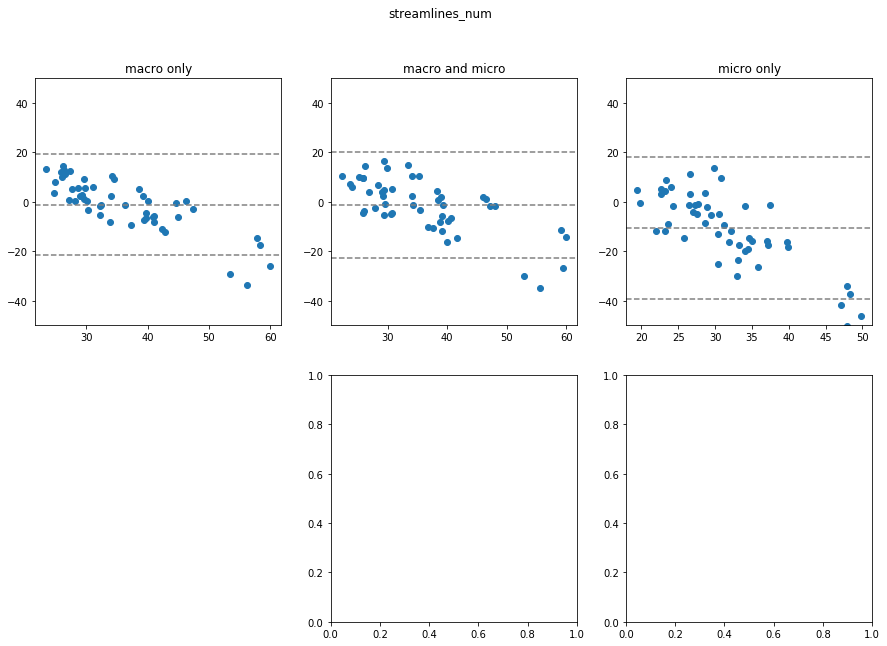

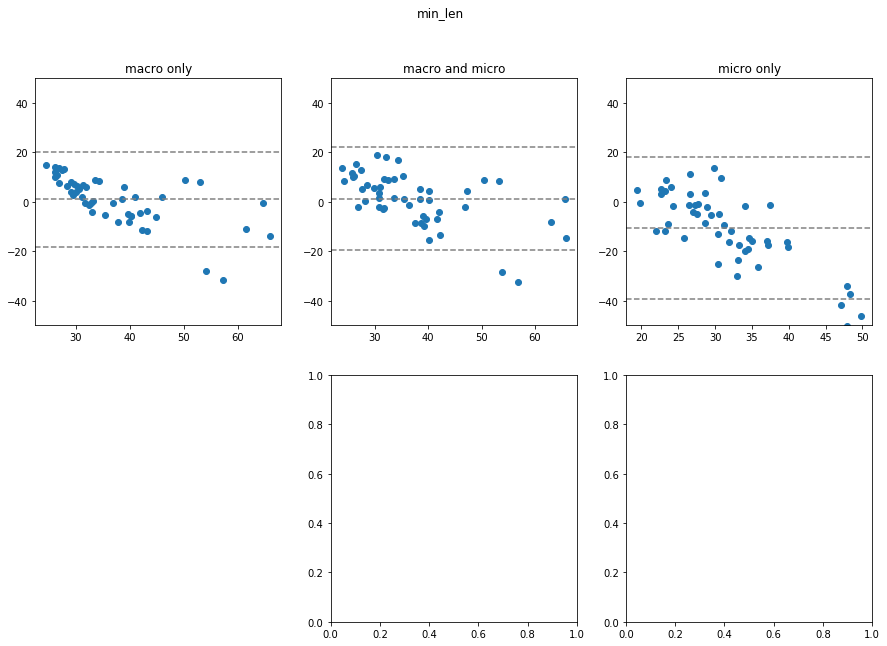

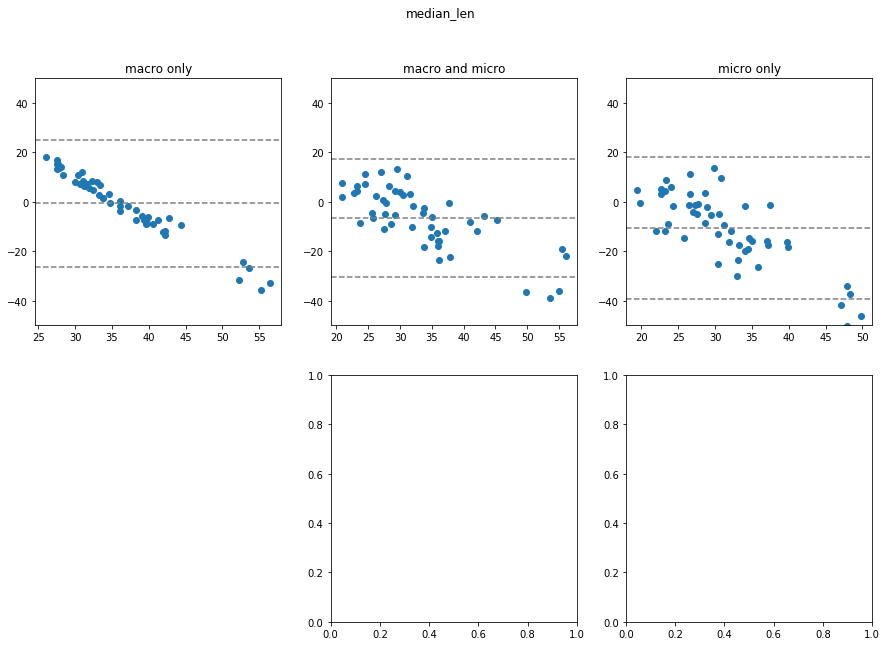

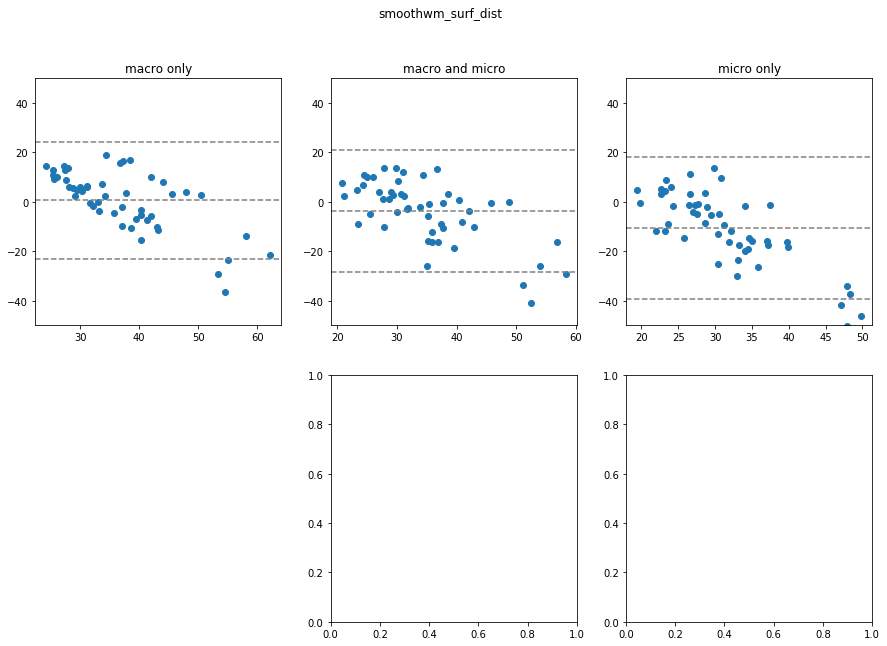

In [20]:
for macrostructural_conn_measure in macrostructural_conn_measures:
    prediction_summary(
        macrostructural_conn_measure, 
        microstructural_conn_measures, 
        effective_conn_measures[0]
    )

# Prediction of P1 amplitudes

===== streamlines_num =====
macro only	score: 0.05	RMSE: 7 +/ 9
macro and micro	score: 0.00	RMSE: 7 +/ 8
micro only	score: 0.00	RMSE: 7 +/ 8
===== min_len =====
macro only	score: 0.22	RMSE: 6 +/ 8
macro and micro	score: 0.02	RMSE: 7 +/ 8
micro only	score: 0.00	RMSE: 7 +/ 8
===== median_len =====
macro only	score: -0.04	RMSE: 7 +/ 9
macro and micro	score: 0.00	RMSE: 7 +/ 8
micro only	score: 0.00	RMSE: 7 +/ 8
===== smoothwm_surf_dist =====
macro only	score: 0.03	RMSE: 7 +/ 9
macro and micro	score: 0.00	RMSE: 7 +/ 8
micro only	score: 0.00	RMSE: 7 +/ 8


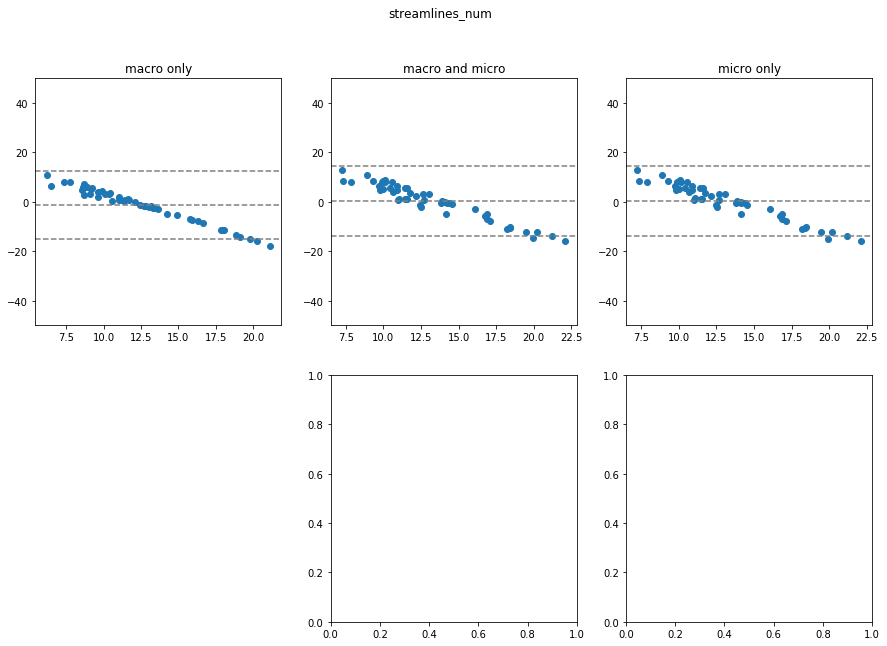

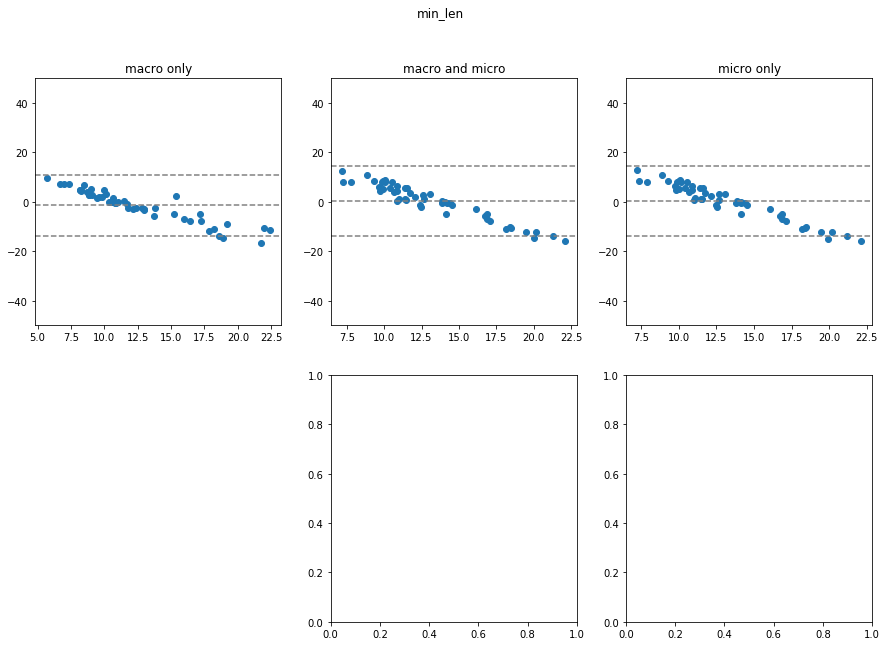

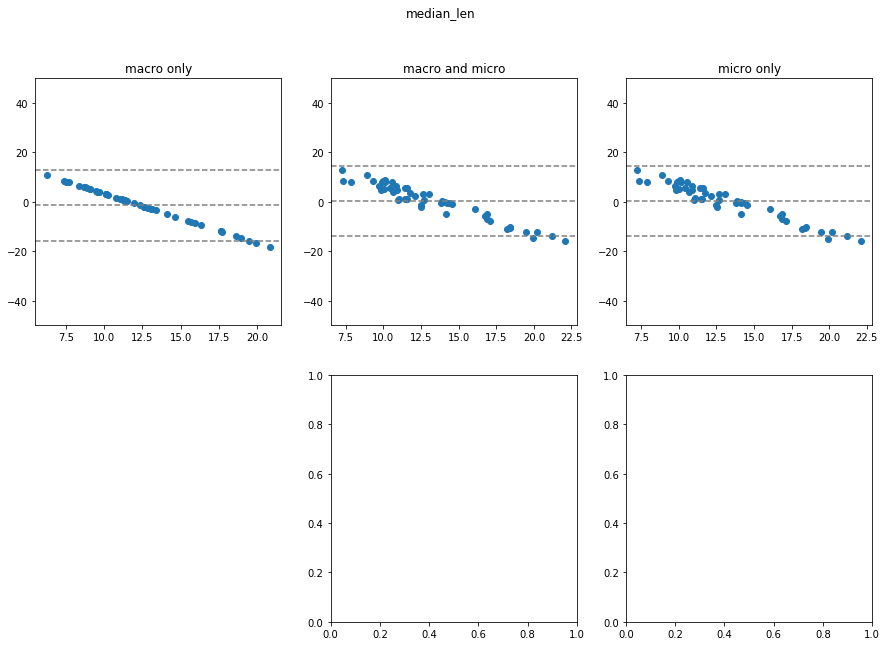

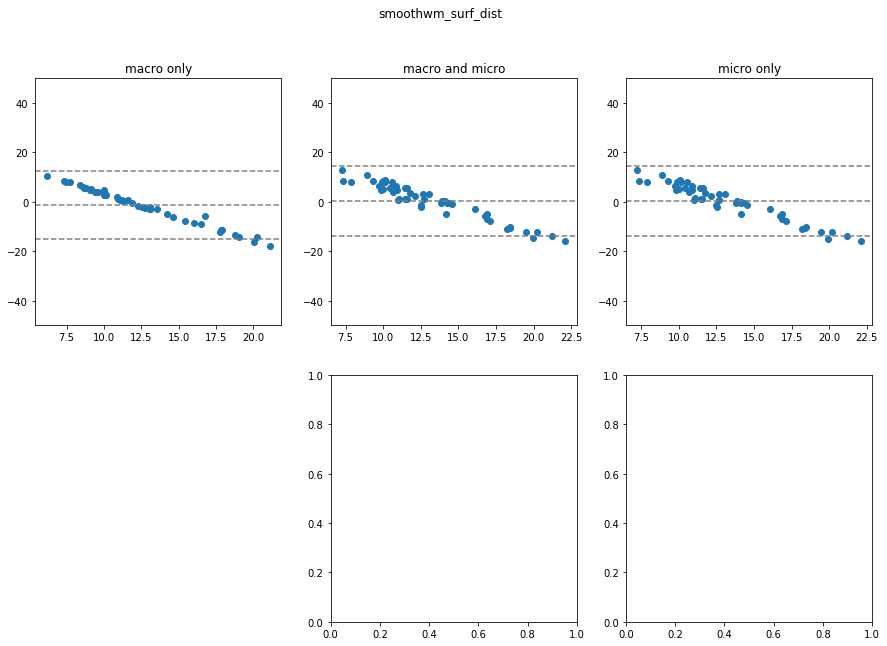

In [15]:
for macrostructural_conn_measure in macrostructural_conn_measures:
    prediction_summary(
        macrostructural_conn_measure, 
        microstructural_conn_measures, 
        effective_conn_measures[1]
    )